<h1>MNIST digit recognition with LeNet</h1>

In this practical session we will build a convolutional neural network that is able to recognise the digits 0-9 in images.

You can run the code in a cell by selecting the cell and pressing Shift+Enter.

<h4>1) Import statements</h4>
First, import some of the packages we will need (run the cell below).

Documentation for each of these packages can be found online: <br>
For numpy: https://docs.scipy.org/doc/numpy-dev/user/quickstart.html <br>
For matplotlib: http://matplotlib.org/api/pyplot_api.html <br>
For lasagne: http://lasagne.readthedocs.io <br>
For random: https://docs.python.org/2/library/random.html <br>

In [3]:
import cPickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import theano
import lasagne
import time
import random
random.seed(0)

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
C:\Users\s119104\AppData\Local\Continuum\Anaconda2\lib\site-packages\theano\tensor\signal\downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


<h4>2) Loading the data</h4>
Download the data from: http://deeplearning.net/data/mnist/mnist.pkl.gz and save it somewhere on your disc. The function below loads the data from the location where you have saved it (path) and stores it in numpy arrays. The data is already split in a train set, a validation set and a test set. Each of these three sets are saved in two separate variables, one containing the labels and one containing the images. The labels are lists of numbers between 0 and 9. The images are 4-dimensional arrays (of the same length) with the image dimensions in the last 2 dimensions.

Change the path in the second cell below to the location where you have saved it and run the two cells.

In [4]:
def loadMNIST(path):
    f = gzip.open(path, 'rb')
    train_set, valid_set, test_set = cPickle.load(f)
    f.close()
    
    train_set_labels = train_set[1]
    train_set_images = np.resize(train_set[0],(len(train_set_labels),1,28,28))
    train_set_images = np.pad(train_set_images,((0,0),(0,0),(2,2),(2,2)),'constant', constant_values=0)
   
    valid_set_labels = valid_set[1]
    valid_set_images = np.resize(valid_set[0],(len(valid_set_labels),1,28,28))
    valid_set_images = np.pad(valid_set_images,((0,0),(0,0),(2,2),(2,2)),'constant', constant_values=0)

    test_set_labels = test_set[1]
    test_set_images = np.resize(test_set[0],(len(test_set_labels),1,28,28))
    test_set_images = np.pad(test_set_images,((0,0),(0,0),(2,2),(2,2)),'constant', constant_values=0)
    
    return train_set_labels, train_set_images, valid_set_labels, valid_set_images, test_set_labels, test_set_images

In [5]:
train_set_labels, train_set_images, valid_set_labels, valid_set_images, test_set_labels, test_set_images = loadMNIST(r'C:\Users\s119104\Documents\Studie\Capita selecta in medical image analysis\mnist.pkl.gz')

<h4>3) Visualising the data</h4>
Let's look at the data we've just loaded! 

How many samples are in each set? (Use .shape to see the dimensions) 

How large are the images? 

How many samples are there for each of the 10 digits? 

Show some of the images with plt.imshow (use cmap='gray_r' for black digits on a white background and interpolation='none' to see the real pixels), you can access one of the training images as: train_set_images[i,0].

There are 50000 samples in the training set, 10000 samples in the validation set and 10000 images in the test set
The image size is 32 by 32
The quantities for all digits are: 
 0: 7877, 
 1: 6990, 
 2: 7141, 
 3: 6824, 
 4: 6313, 
 5: 6876, 
 6: 7293, 
 7: 6825, 
 8: 6958, 
 9: 6903
An example of the image


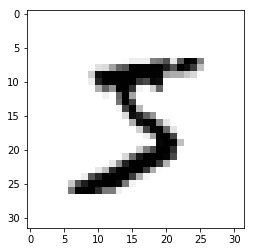

In [6]:
# Number of samples
train_sample_size = train_set_images.shape[0]
valid_sample_size = valid_set_images.shape[0]
test_sample_size = test_set_images.shape[0]
print("There are %d samples in the training set, %d samples in the validation set and %d images in the test set" 
      % (train_sample_size, valid_sample_size, test_sample_size))

# Image sizes
image_size_d1 = train_set_images.shape[2]
image_size_d2 = train_set_images.shape[3]
print("The image size is %d by %d" % (image_size_d1, image_size_d2))

# Digit sample counts
digit_sample_sizes = np.zeros(10)

# Counting the number of samples for each of the digits in the training set
for i in range(train_sample_size):
    for j in range(10):
        if train_set_labels[i] == j:
            digit_sample_sizes[j - 1] += 1

# Counting the number of samples for each of the digits in the validation set
for i in range(valid_sample_size):
    for j in range(10):
        if valid_set_labels[i] == j:
            digit_sample_sizes[j - 1] += 1

# Counting the number of samples for each of the digits in the test set
for i in range(test_sample_size):
    for j in range(10):
        if test_set_labels[i] == j:
            digit_sample_sizes[j - 1] += 1

print("The quantities for all digits are: \n 0: %d, \n 1: %d, \n 2: %d, \n 3: %d, \n 4: %d, \n 5: %d, \n 6: %d, \n 7: %d, \n 8: %d, \n 9: %d" %
     (digit_sample_sizes[0], digit_sample_sizes[1], digit_sample_sizes[2], digit_sample_sizes[3], digit_sample_sizes[4], digit_sample_sizes[5], 
     digit_sample_sizes[6], digit_sample_sizes[7], digit_sample_sizes[8], digit_sample_sizes[9]))  

# Image example
print("An example of the image")
plt.imshow(train_set_images[0,0], cmap='gray_r', interpolation='none')



<h4>4) One-hot-encoding</h4>
Convert the labels from a number between 0 and 9 to 'one-hot-encoding'. This means that for a label with number 3, there should be a 1 at element 3 and 0 everywhere else, i.e. [0, 0, 0, 1, 0, 0, 0, 0 ,0 ,0]. These are our target nodes, the node at position 3 should be active when the input image shows a 3. The code below does this for the training labels. 

Do the same for the validation labels!

In [7]:
# Training labels
train_hot_labels = np.zeros((len(train_set_labels),10),dtype=np.int16)        
for n in xrange(10):
    train_hot_labels[:,n] = train_set_labels==n

print("The first 10 examples of hot encoding the training labels")
print train_set_labels[:10]
print train_hot_labels[:10]

# Validation labels
valid_hot_labels = np.zeros((len(valid_set_labels),10),dtype=np.int16)        
for n in xrange(10):
    valid_hot_labels[:,n] = valid_set_labels==n

print("The first 10 examples of hot encoding the validation labels")
print valid_set_labels[:10]
print valid_hot_labels[:10]

# Test labels
test_hot_labels = np.zeros((len(test_set_labels),10),dtype=np.int16)        
for n in xrange(10):
    test_hot_labels[:,n] = test_set_labels==n

print("The first 10 examples of hot encoding the test labels")
print test_set_labels[:10]
print test_hot_labels[:10]

The first 10 examples of hot encoding the training labels
[5 0 4 1 9 2 1 3 1 4]
[[0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]
The first 10 examples of hot encoding the validation labels
[3 8 6 9 6 4 5 3 8 4]
[[0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0]]
The first 10 examples of hot encoding the test labels
[7 2 1 0 4 1 4 9 5 9]
[[0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]]


<h4>5) Building the network</h4>
The function below builds the LeNet network as we looked at in the lecture. The layers are defined as functions with as input the previous network and as output the new network with the new layer added. The print network.output_shape statement shows the dimensions after the current layer. 

Can you recognise all the elements of the network from the lecture?

In [8]:
def buildLeNet(X1):
    inputlayer = lasagne.layers.InputLayer(shape=(None, 1, 32, 32),input_var=X1)    
    print inputlayer.output_shape
    
    layer1 = lasagne.layers.Conv2DLayer(inputlayer, num_filters=6, filter_size=(5,5), nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.GlorotUniform())
    print layer1.output_shape 
    
    layer2 = lasagne.layers.MaxPool2DLayer(layer1, pool_size=(2, 2))
    print layer2.output_shape 
    
    layer3 = lasagne.layers.Conv2DLayer(layer2, num_filters=16, filter_size=(5,5), nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.GlorotUniform())
    print layer3.output_shape 
    
    layer4 = lasagne.layers.MaxPool2DLayer(layer3, pool_size=(2, 2))
    print layer4.output_shape 
    
    layer4 = lasagne.layers.flatten(layer4)
    print layer4.output_shape 
    
    layer5 = lasagne.layers.DenseLayer(layer4,num_units=120,nonlinearity=lasagne.nonlinearities.rectify)    
    print layer5.output_shape 
    
    layer6 = lasagne.layers.DenseLayer(layer5,num_units=84,nonlinearity=lasagne.nonlinearities.rectify)
    print layer6.output_shape 
    
    outputlayer = lasagne.layers.DenseLayer(layer6,num_units=10,nonlinearity=lasagne.nonlinearities.softmax)     
    print outputlayer.output_shape 
    
    return layer1, layer2, layer3, layer4, layer5, layer6, outputlayer

In [14]:
X = theano.tensor.tensor4()
Y = theano.tensor.matrix()
layer1, layer2, layer3, layer4, layer5, layer6, outputlayer = buildLeNet(X)

(None, 1, 32, 32)
(None, 6, 28, 28)
(None, 6, 14, 14)
(None, 16, 10, 10)
(None, 16, 5, 5)
(None, 400)
(None, 120)
(None, 84)
(None, 10)


<h4>6) Training function</h4>
Define the functions for training the network. We will use negative log likelihood (called categorical cross-entropy in lasagne) as loss function (second row) and stochastic gradient descent with momentum as optimiser (fourth row).

In [15]:
outputtrain = lasagne.layers.get_output(outputlayer) #function that gets the output from the network defined before.
trainloss = lasagne.objectives.categorical_crossentropy(outputtrain, Y).mean() #function that computes the mean crossentropy between the output and the real labels.
params = lasagne.layers.get_all_params(outputlayer, trainable=True) #function that gets all the parameters (weights) in the network.
updates = lasagne.updates.momentum(trainloss, params, learning_rate=0.001) #function that performs an update of the weights based on the loss.
train = theano.function(inputs=[X, Y], outputs=trainloss, updates=updates, allow_input_downcast=True) #function that does all the above based on training samples X and real labels Y.

<h4>7) Validation function</h4>
Define a function to validate the network.

In [16]:
validate = theano.function(inputs=[X, Y], outputs=trainloss, allow_input_downcast=True) #function that computes the loss without performing an update

<h4>8) Test function</h4>
Define the functions for testing the network. 

In [17]:
outputtest = lasagne.layers.get_output(outputlayer, deterministic=True) #function that gets the output from the network defined before.
test = theano.function(inputs=[X], outputs=outputtest, allow_input_downcast=True) #function that gets the output based on input X

<h4>9) Training the network</h4>
Do the training in random batches of a specific number of samples (we set the values below to 250 batches of 100 samples). 

Use random.sample(a,n) to select a random batch of n samples from array a. 

Next, use the train(X,Y) function we have defined in 6) to perform an update of the network based on a random batch of training images X and training labels Y. 

The train function returns the loss. Save the loss of each training batch in the variable 'losslist' so we can look at them later (you can use .append() to add the current loss to the list).

Also keep track of the loss for random batches from the validation set to see if your network is not overfitting on the training set. You can use validate(X,Y) from 7) to compute the loss on the validation set (without doing an update).

<b>Remember</b> that if you restart the training process from the beginning you also need to reinitialise the network by running the cells starting from 5) again.

In [ ]:
trainingsamples = np.arange(len(train_set_labels)) #numbers from 0 until the number of samples
validsamples = np.arange(len(valid_set_labels))


minibatches = 250
minibatchsize = 10

losslist = []
validlosslist = []

t0 = time.time()

for i in xrange(minibatches):
    print("Currently at batch %d" % i)
    
    # Random train sample information. IMPORTANT: Use the hot encoded labels (that's the way the algorithm works)
    random_train_samples = random.sample(trainingsamples, minibatchsize)
    random_train_labels = train_hot_labels[random_train_samples]
    random_train_images = train_set_images[random_train_samples]
    
    # Random validation sample information IMPORTANT: Use the hot encoded labels (that's the way the algorithm works)
    random_valid_samples = random.sample(validsamples, minibatchsize)
    random_valid_labels = valid_hot_labels[random_valid_samples]
    random_valid_images = valid_set_images[random_valid_samples]
    
    print(random_train_labels.shape)
    print(random_train_images.shape)
    
    new_train_loss = train(random_train_images, random_train_labels)
    losslist.append(new_train_loss)
    
    new_valid_loss = validate(random_valid_images, random_valid_labels)
    validlosslist.append(new_valid_loss)
    #select random training en validation samples and perform training and validation steps here.
    
t1 = time.time()
print 'Training time: {} seconds'.format(t1-t0)

In [74]:
print(validlosslist)

[array(2.3392624122406485), array(2.288798833139053), array(2.2854755939962565), array(2.2994424719947753)]


<h4>9) Loss curves</h4>
Plot the loss curves for the training and validation sets (use plt.plot(losslist) for the training loss). 

Is 250 batches enough to train the network? How many do we need? 

What happens if you change the learning rate in 6)? 

What happens if you change the minibatchsize? 

What happens if you use another optimizer? 

Try to get the loss as low as possible! 

What happens if you make changes to the network? Use for example more or less filters or nodes, remove a layer, etc.

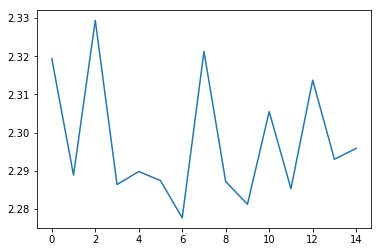

In [19]:
#Plot loss curve training set
plt.plot(losslist)


<h4>10) Evaluation on the test set</h4>
Evaluate the network on the test set with the test(X) function we have defined in 8). You can use np.argmax() to select the node with the highest probability. 

How well did it do? How many of the 10 000 test samples did it label correctly?

<h4>11) Visualising what the network has learned</h4>
To see what is happening within the network we can visualise the learned filters and their feature maps. We now define an additional function that obtains the feature maps after the first layer.

In [ ]:
outputlayer1 = lasagne.layers.get_output(layer1) 
outputfeatures = theano.function(inputs=[X], outputs=outputlayer1, allow_input_downcast=True) 

<h4>12) Visualising the features</h4>
Let's look at the feature maps after the first layer for one of the images from the test set. We have defined the function 'outputfeatures' for that. 

Look at the shape of the features variable. 

Visualise the 6 features maps for some of the 10 000 test samples with plt.imshow

In [ ]:
features = outputfeatures(test_set_images)

<h4>13) Visualising the filters</h4>
Let's look at the filters that are learned. We can use the lasagne function 'get_all_param_values' for that. These are the filters that are applied to the images to obtain the feature maps that we saw above.

Look at the shape of the filters and biases.

Visualise the 6 filters of the first layer with plt.imshow. Do you see any structure in the learned filters?

In [ ]:
weights = lasagne.layers.get_all_param_values(layer1)
filters = weights[0]
biases = weights[1]

<h4>14) Visualising other layers </h4>
Can you also visualise features and kernels of other layers? Take for example a look at the features after the third layer.

<h4>15) Saving a trained model to disc</h4>
Training a network can often take a very long time. It's therefore useful to be able save a trained model to disc. You can use the functions below to save and load a trained network. This is especially useful for the project next week.

In [ ]:
def save_weights(filename,network):
    with open(filename, 'wb') as f:
        cPickle.dump(lasagne.layers.get_all_param_values(network), f)
        
def load_weights(filename, network):
    with open(filename, 'rb') as f:
        lasagne.layers.set_all_param_values(network, cPickle.load(f))